# RL analysis on Unsupervised Attention Mechanism
---
In this notebook, we demonstrated the MDL changes ofa DQN agent with or without RN with OpenAI Gym's LunarLander-v2 environment.

### 1. Import the Necessary Packages

In [8]:
import gym
import random
import torch
import numpy as np
import math 
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Instantiate the Environment and Agent

Initialize the environment

In [9]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


Here we specify the agent to use:

In [10]:
from dqn_agent import Agent, Agent_UAM

agent = Agent(state_size=8, action_size=4, seed=0,qnet='DQN-RNLN')

# watch an untrained agent
state = env.reset()
for j in range(200):
    action = agent.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 
        
env.close()

### 3. Train the Agent with DQN variants

Train the agents from scratch. 

In [11]:
def dqn_uam(agentName, n_episodes=1000, max_t=1000,eps_start=1.0, eps_end=0.01, eps_decay=0.95, runs=1):
    """Deep Q-Learning - Unsupervised Attention Mechanism
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """

    scores_runs = 0*np.ndarray((runs,n_episodes)) # containing scores for each runs
    window_size = 50
    eps = eps_start                               # initialize epsilon
    solved = []
    MDL_local, MDL_target = [], []
    for run in np.arange(runs):
        MDL_loca, MDL_target = [], []

        scores_window = deque(maxlen=window_size)             # last n scores
        agent = Agent_UAM(state_size=8, action_size=4, seed=run, qnet=agentName)
        firstPast = True
        scores = []                               # list containing scores from each episode
        for i_episode in range(1, n_episodes+1):
            state = env.reset()
            score = 0
            for t in range(max_t):
                action = agent.act(state, eps)
                next_state, reward, done, _ = env.step(action)
                l_local, l_target = agent.step(state, action, reward, next_state, done)
                if l_local != -1:
                    MDL_local.append(l_local)
                    MDL_target.append(l_target)
                state = next_state
                score += reward
                if done:
                    break 
            scores_window.append(score)       # save most recent score
            scores.append(score)              # save most recent score
            eps = max(eps_end, eps_decay*eps) # decrease epsilon
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
            if i_episode % 100 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            if np.mean(scores_window)>=200.0 and firstPast:
                firstPast = False
                solved.append(i_episode-window_size)
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-window_size, np.mean(scores_window)))
                # torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
                # break
        scores_runs[run,:]=scores
    return scores_runs,np.array(solved),MDL_local,MDL_target


In [12]:
n = 1    # runs
m = 100  # episodes
alpha = 0.1


In [13]:
print('--------------------------')
print('DQN')
scores1,solved1,MDL_local,MDL_target = dqn_uam('DQN-UAM',n_episodes=m,runs=n)
np.save('./scores/dqn_mdl_local.npy',MDL_local)
np.save('./scores/dqn_mdl_target.npy',MDL_target)


--------------------------
DQN
Episode 100	Average Score: -151.33


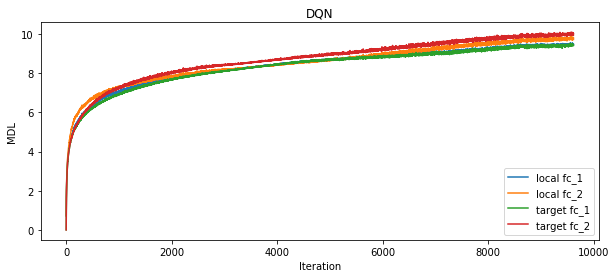

In [37]:
MDL_local = np.load('./scores/dqn_mdl_local.npy',allow_pickle=True)
MDL_target = np.load('./scores/dqn_mdl_target.npy',allow_pickle=True)

MDL_local, MDL_target = np.array(MDL_local), np.array(MDL_target)
T = np.arange(MDL_local.shape[0])

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)

ax.plot(T, MDL_local[:,1],label='local fc_1')
ax.plot(T, MDL_local[:,2],label='local fc_2')
ax.plot(T, MDL_target[:,1],label='target fc_1')
ax.plot(T, MDL_target[:,2],label='target fc_2')

ax.set_ylabel('MDL')
ax.set_xlabel('Iteration')
ax.legend()
ax.set_title('DQN')

fig.savefig('uam_dqn.png',layout='tight')


In [17]:
print('--------------------------')
print('DQN-RN')
scores3,solved3,MDL_local,MDL_target = dqn_uam('DQN-RN-UAM',n_episodes=m,runs=n)
np.save('./scores/dqnrn_mdl_local.npy',MDL_local)
np.save('./scores/dqnrn_mdl_target.npy', MDL_target)


--------------------------
DQN-RN
Episode 100	Average Score: -188.60


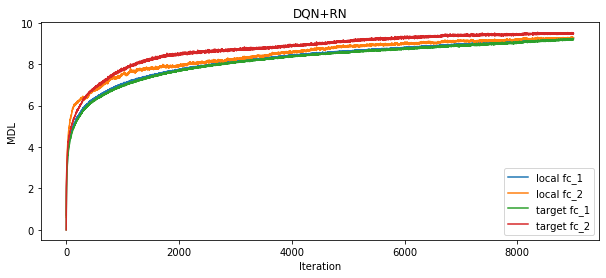

In [38]:
MDL_local = np.load('./scores/dqnrn_mdl_local.npy',allow_pickle=True)
MDL_target = np.load('./scores/dqnrn_mdl_target.npy',allow_pickle=True)


MDL_local, MDL_target = np.array(MDL_local), np.array(MDL_target)
T = np.arange(MDL_local.shape[0])

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)

ax.plot(T, MDL_local[:,1],label='local fc_1')
ax.plot(T, MDL_local[:,2],label='local fc_2')
ax.plot(T, MDL_target[:,1],label='target fc_1')
ax.plot(T, MDL_target[:,2],label='target fc_2')

ax.set_ylabel('MDL')
ax.set_xlabel('Iteration')
ax.legend()
ax.set_title('DQN+RN')

fig.savefig('uam_dqnrn.png',layout='tight')
